In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
class my_neural_network:
    
    def __init__(self, hidden_layer_plan):
        
        '''
        Initialization function.
        
        input: 
        layer_plan : data_type = list
        
        List cointaing the number of neurons in every layers for the neural network. The first and last elements of
        layer_plan corresponds to number of input features and the output value. 
        The rest of the elements between them corresponds to the neurons in hidden layers.
        More the Hidden Layers implies deeper the network!
        '''
        
        #dataset
        '''Object to store the name of the dataset'''
        self.dataset = None
        
        #input and output data
        '''Objects to store the input and the coutput data. An attribute is additionally set to store the calculated output from the neural network'''
        self.input_data = None
        self.output_data = None
        self.predicted_output =None
        
        #train and test data
        '''Objects to store the Training data and Testing data. This is doen during the training and test data split'''
        self.training_data = None
        self.testing_data = None
        
        #layer details
        '''The attributes defining the deep network that is the number of hidden layers and its respective neurons '''
        self.hidden_layer_plan = hidden_layer_plan
        self.layer_dimensions = None
        self.num_of_layers = None
        
        #Batching
        ''' List to store the mini batches'''
        self.mini_batches = []
        
        #Forward Activation
        ''' Objects to utilize during Forward Propagation'''
        self.activation_function_name = None
        self.activations, self.Z = [], [] # Lists to store the Activation outputs and their respective Linear Functions
        
        #Backward Activation
        self.dActivations = []
        
        #Error_method and loss
        self.error_method = None
        self.loss_derivative = None
        self.cost = []
        self.cost_value = None
        
        #Network parameters
        self.network_weights, self.gradient_weights,self.momentum_weights, self.rms_weights = [],[],[],[]
        self.network_bias, self.gradient_bias,self.momentum_bias, self.rms_bias = [],[],[],[]
        #optimizer
        self.optimizer = None
        self.hyperparameters = []
    def __repr__(self):
        ''' Representative function to welcome the user for collaborating with the new AI trainer'''
        return 'Hello there!! I am your new AI trainer......!'
    
    
    def load_dataset(self, file):
        ''' 
        To load dataset 
        
        input:
        file : data_type: string
        File name consisting the inputs and outputs. The last column in the file is the output.
        '''
        self.dataset = np.loadtxt(file)
        self.input_data = self.dataset[:,:-1]
        self.output_data = self.dataset[:,-1]
        
        #Normalization
        '''Normalization helps to modulate teh data such that teh values lies along 0 and 1. This is helpful when using sigmoid functions or any activation functions'''
        max_inputs = np.amax(self.input_data, axis=0)
        min_inputs = np.amin(self.input_data, axis=0)
        diff_inputs = max_inputs - min_inputs
        self.input_data = np.divide((self.input_data - min_inputs),diff_inputs)
        
        max_outputs = np.amax(self.output_data, axis=0)
        min_outputs = np.amin(self.output_data, axis=0)
        diff_outputs = max_outputs - min_outputs
        self.output_data = np.divide((self.output_data - min_outputs), diff_outputs)
        
        #Layer planning
        self.layer_dimensions = [self.input_data.shape[1]]+self.hidden_layer_plan+[1] #1 corresponds to columns in O/P
        self.num_of_layers = len(self.layer_dimensions)
        
    def test_train_split(self, split = 0.7, masking=True):
        '''
        This function is utilized to segragate the complete data into training and testing data.
        '''
        
        n_total = int(self.dataset.shape[0])
        n_train = int(split*n_total)
        
        if masking:
            mask = np.zeros((n_total), dtype=bool)
            mask[:n_train] = True

            np.random.shuffle(mask)

            X_train = self.input_data[mask]
            Y_train = self.output_data[mask]

            X_test = self.input_data[~mask]
            Y_test = self.output_data[~mask]
        else:
            X_train = self.input_data[:n_train,:]
            Y_train = self.output_data[:n_train]

            X_test = self.input_data[n_train:,:]
            Y_test = self.output_data[n_train:]

        self.training_data = (X_train.transpose(), Y_train)
        self.testing_data = (X_test.transpose(), Y_test)
    
    def network_parameters_initialization(self):
        ''' Helps to initialize the network parameters '''
        
        np.random.seed(1)

        for i in range(1,self.num_of_layers):
            self.network_weights.append(np.random.randn(self.layer_dimensions[i], 
                                                                         self.layer_dimensions[i-1]))#*np.sqrt(4/self.num_of_layers))
            self.network_bias.append(np.random.randn(self.layer_dimensions[i],1))
            
            assert(self.network_weights[i-1].shape == (self.layer_dimensions[i], 
                                                                         self.layer_dimensions[i-1]))
            assert(self.network_bias[i-1].shape == (self.layer_dimensions[i],1))
            
            self.gradient_weights.append(np.zeros_like(self.network_weights[i-1])) #np.zeros((self.layer_dimensions[i], self.layer_dimensions[i-1]))
                                                                         #
            self.gradient_bias.append(np.zeros_like(self.network_bias[i-1]))#np.zeros((self.layer_dimensions[i],1))
            
            self.momentum_weights.append(np.zeros_like(self.network_weights[i-1]))
            
            self.momentum_bias.append(np.zeros_like(self.network_bias[i-1]))
            
            self.rms_weights.append(np.zeros_like(self.network_weights[i-1]))
            
            self.rms_bias.append(np.zeros_like(self.network_bias[i-1]))

    def batching(self, batching = False, batch_size = None):
        '''
        This is useful for Stochasting Batching and Mini Batching of teh training output

        Size is always in powers of 2 (32,64,128,...)
        '''
        num_examples = self.training_data[0].shape[1]
              
        
        if batching:
            
            training_input = self.training_data[0]
            training_output = self.training_data[1]
            
            #mini_batches = []
            
            number_of_batches = int(num_examples/batch_size)
            
            for j in range(0,number_of_batches):
                mini_train_input = training_input[:,(j*batch_size):((j+1)*batch_size)]
                mini_train_output = training_output[(j*batch_size):((j+1)*batch_size)]
                self.mini_batches.append((mini_train_input,mini_train_output))
                
            if num_examples % batch_size != 0:
                mini_train_input = training_input[:,(number_of_batches*batch_size):]
                mini_train_output = training_output[(number_of_batches*batch_size):]
                self.mini_batches.append((mini_train_input,mini_train_output))
        else:
            
            self.mini_batches = [self.training_data]

    def activation_function(self,Z):
        '''In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs. [Wikipedia]'''
        
        if self.activation_function_name == "sigmoid":
            return self.sigmoid(Z)
        elif self.activation_function_name == "relu":
            return self.relu(Z)
        elif self.activation_function_name == "tanh":
            return self.tanh(Z)
        
    def activation_function_derivative(self,Z):
        ''' Functions to call the corresponding derivatives of the activation functions'''
        if self.activation_function_name == "sigmoid":
            return self.sigmoid_derivative(Z)
        elif self.activation_function_name == "relu":
            return self.relu_derivative(Z)
        elif self.activation_function_name == "tanh":
            return self.tanh_derivative(Z)
        

    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))

    def sigmoid_derivative(self,Z):
        return self.sigmoid(Z)*(1-self.sigmoid(Z))
    
    def relu(self,Z):
        return np.maximum(0,Z)
    
    def relu_derivative(self,Z):
        dz = np.ones_like(Z)
        dz[Z<=0] = 0
        return dz

    def tanh(self,Z):
        return np.tanh(Z)
    
    def tanh_derivative(self,Z):
        return np.reciprocal(np.square(np.cosh(Z))) #sech^2(Z)

    def forward_propagation(self, X, check_w = None, check_b = None):
        
        self.activations = [X]
        self.Z, self.dActivations = [],[]

        #This is useful during gradient checking
        if check_w == None and check_b == None:
            weights = self.network_weights
            bias = self.network_bias
        else:
            weights = check_w
            bias = check_b
            
        for l in range(self.num_of_layers-1):

            Z = np.dot(weights[l], self.activations[l]) + bias[l]

            activated_Z = self.activation_function(Z)

            self.Z.append(Z)
            self.activations.append(activated_Z)

    def cost_function(self,Y, error_method = 'MSE',test = False):
        ''' Using cost function helps to determine the amount of loss created using the parameters in forward propagation. Minimizing the 
        cost function is the main objective
        '''
        self.error_method = error_method
        
        #if test:
        #    y_o = self.testing_data[1]
        #else:
        #    y_o = Y
        
        if error_method == 'MSE':
            diff = self.activations[-1] - Y
            cost = 0.5*np.mean(np.square(diff)) #MSE Calculation
            #self.cost_value = np.squeeze(cost) ------------ to be added at the end of the mini batching

        return np.squeeze(cost)

    def cost_function_derivative(self,y_o, test=False):
        #if test:
        #    y_o = self.testing_data[1]
        #else:
        #    y_o = y_o
            
        if self.error_method == 'MSE':
            delC_delA = self.activations[-1] - y_o

        self.loss_derivative = delC_delA

    def back_propagation(self,X,Y):
        ''' To find the gradient, Back propagation is used. Gradients help to find the flatness i.e, minima'''
        
        delC_delA = self.loss_derivative#*(1.0/X.shape[1])

        #For Last Layer

        #delC _delZ = delC_delA * delA_delZ
        delC_delZ = delC_delA*self.activation_function_derivative(self.Z[-1])###########*(1.0/X.shape[1])
        #delC_delB =  delC_delA * delA_delZ * delZ_delB
        delC_delB = np.mean(delC_delZ, axis=1,keepdims = True)################*(1.0/X.shape[1]) # Changed mean to SUM
        #delC_delW =  delC_delA * delA_delZ * delZ_delW
        delC_delW = np.dot(delC_delZ,self.activations[-2].transpose())###############*(1.0/X.shape[1])

        self.gradient_weights[-1] = delC_delW
        assert ( self.gradient_weights[-1].shape == self.network_weights[-1].shape)
        self.gradient_bias[-1] = delC_delB#.reshape(self.network_bias[-1].shape)
        assert ( self.gradient_bias[-1].shape == self.network_bias[-1].shape)

        for i in reversed(range(2,self.num_of_layers)):
            delC_delA = np.dot(self.network_weights[i-1].transpose(),delC_delZ)#################*(1.0/X.shape[1])
            delC_delZ = delC_delA*self.activation_function_derivative(self.Z[i-2])
            delC_delB = np.sum(delC_delZ, axis=1)#################*(1.0/X.shape[1]) # Changed mean to SUM
            delC_delW = np.dot(delC_delZ,self.activations[i-2].transpose())#################*(1.0/X.shape[1])#*

            self.gradient_weights[i-2] = delC_delW
            assert ( self.gradient_weights[i-2].shape == self.network_weights[i-2].shape)
            self.gradient_bias[i-2] = delC_delB.reshape(self.network_bias[i-2].shape)
            assert ( self.gradient_bias[i-2].shape == self.network_bias[i-2].shape)

    def vector_to_list(self,array):
        
        weight_shapes = [arr_w.shape for arr_w in self.network_weights]
        bias_shapes = [arr_b.shape for arr_b in self.network_bias]
        
        t=0
        w,b = [],[]
        for m,n in zip(weight_shapes,bias_shapes):
            
            ini = t
            t = t+(m[0]*m[1])
            assert(t-ini == m[0]*m[1])
            w.append(array[ini : t,0].reshape(m))
            
            ini = t
            t = t+(n[0]*n[1])
            assert(t-ini == n[0]*n[1])
            b.append(array[ini : t,0].reshape(n))
            
        return w,b

    def gradient_checking(self,X,Y,error_method='MSE'):
        """Implementation of gradient checking"""
        
        eps = 1e-2
        
        conglomerate_network_array = np.array([]).reshape(-1,1)
        conglomerate_gradient_array = np.array([]).reshape(-1,1)
        
        for p,r in zip(self.network_weights, self.network_bias):
            conglomerate_network_array = np.concatenate((conglomerate_network_array,p.reshape(-1,1),r.reshape(-1,1)))
            
        
        for dw,db in zip(self.gradient_weights,self.gradient_bias):
            conglomerate_gradient_array = np.concatenate((conglomerate_gradient_array,dw.reshape(-1,1),db.reshape(-1,1)))
        
        #central difference
        
        func_plus = np.zeros_like(conglomerate_network_array)
        func_minus = np.zeros_like(conglomerate_network_array)
        
        approx_graident = np.zeros_like(conglomerate_gradient_array)
        
        for i in range(func_plus.shape[0]):
            
            x_plus_eps = np.copy(conglomerate_network_array)
            
            x_plus_eps[i,0] = x_plus_eps[i,0]+eps
            
            weights_plus, bias_plus = self.vector_to_list(x_plus_eps)
            
            self.forward_propagation(X,check_w = weights_plus,check_b = bias_plus)
            
            cost_p = self.cost_function(Y,error_method)
            
            func_plus[i,0] = cost_p
            
            #########################################################################################
            x_minus_eps = np.copy(conglomerate_network_array)
            
            x_minus_eps[i,0] = x_plus_eps[i,0]-eps
            
            weights_minus, bias_minus = self.vector_to_list(x_minus_eps)
            
            self.forward_propagation(X, check_w=weights_minus, check_b=bias_minus)
            
            cost_m = self.cost_function(Y,error_method)
            
            func_minus[i,0] = cost_m
            
            ###############################################################################################
            approx_graident[i,0] = (func_plus[i,0] - func_minus[i,0])/(2*eps)
            ###############################################################################################
            #pint('the grad difference is ', approx_graident[i,0] - conglomerate_gradient_array[i,0])
        assert(approx_graident.shape == conglomerate_gradient_array.shape)    
        
        numerator= np.linalg.norm(approx_graident - conglomerate_gradient_array)
        denominator = np.linalg.norm(approx_graident)+np.linalg.norm(conglomerate_gradient_array)
        
        difference = numerator/denominator
        print('\n Gradient Checking difference : ', difference)

    def update_parameters_GD(self,learning_rate):
            ''' Implementation of gradient descent method '''
            for p in range(1,self.num_of_layers):

                self.network_weights[p-1] -= learning_rate*self.gradient_weights[p-1]

                self.network_bias[p-1] -= learning_rate*self.gradient_bias[p-1]

    
    def update_parameters_Momentum(self,learning_rate,beta1):
        '''Implementation of Gradient descent with Momentum Method'''
        
        for p in range(1,self.num_of_layers):
            
            self.momentum_weights[p-1] = beta1*self.momentum_weights[p-1] + (1-beta1)*self.gradient_weights[p-1]
            self.momentum_bias[p-1] = beta1*self.momentum_bias[p-1] + (1-beta1)*self.gradient_bias[p-1]
            
            self.network_weights[p-1] -= learning_rate*self.momentum_weights[p-1]
            self.network_bias[p-1] -= learning_rate*self.momentum_bias[p-1]
            
    def update_parameters_RMSProp(self, learning_rate,beta2,epsilon=1e-8):
        ''' Implementation of RMS Prop optimization'''
        
        for p in range(1,self.num_of_layers):
            
            self.rms_weights[p-1]= beta2*self.rms_weights[p-1] + (1-beta2)*(self.gradient_weights[p-1])**2
            self.rms_bias[p-1] = beta2*self.rms_bias[p-1] + (1-beta2)*(self.gradient_bias[p-1])**2
            
            self.network_weights[p-1] -= (learning_rate*self.gradient_weights[p-1])/(np.sqrt(self.rms_weights[p-1])+epsilon)
            self.network_bias[p-1] -= (learning_rate*self.gradient_bias[p-1])/(np.sqrt(self.rms_bias[p-1])+epsilon)
        
    def update_parameters_Adam(self,learning_rate,beta1, beta2, epsilon=1e-8):
        '''Implementation of Adaptive Moment Estimation(Adam) optimization'''
        
        temp_momentum_weights, temp_momentum_bias, temp_rms_weights, temp_rms_bias = [],[],[],[]
        
        for p in range(1,self.num_of_layers):
            
            self.momentum_weights[p-1] = beta1*self.momentum_weights[p-1] + (1-beta1)*self.gradient_weights[p-1]
            self.momentum_bias[p-1] = beta1*self.momentum_bias[p-1] + (1-beta1)*self.gradient_bias[p-1]
            
            temp_momentum_weights.append(self.momentum_weights[p-1]/(1-beta1**p))
            temp_momentum_bias.append(self.momentum_bias[p-1]/(1-beta1**(p)))
            
            self.rms_weights[p-1]= beta2*self.rms_weights[p-1] + (1-beta2)*(self.gradient_weights[p-1])**2
            self.rms_bias[p-1] = beta2*self.rms_bias[p-1] + (1-beta2)*(self.gradient_bias[p-1])**2
            
            temp_rms_weights.append(self.rms_weights[p-1]/(1-beta2**p))
            temp_rms_bias.append(self.rms_bias[p-1]/(1-beta2**p))
            
            self.network_weights[p-1] -= (learning_rate*temp_momentum_weights[p-1])/(np.sqrt(temp_rms_weights[p-1])+epsilon)
            self.network_bias[p-1] -= (learning_rate*temp_momentum_bias[p-1])/(np.sqrt(temp_rms_bias[p-1])+epsilon)

    def accuracy(self):
        assert(np.size(self.activations[-1]) == np.size(self.testing_data[1]))
        
        error_percent = np.absolute(np.mean(np.divide(np.mean(self.activations[-1] - self.testing_data[1]),np.mean(self.testing_data[1]))))
        print('The Accuracy is :', (1-error_percent)*100)

    def evaluate(self):
        
        prediction_test = self.testing_data[0]

        self.forward_propagation(prediction_test)
        
        cost_test = self.cost_function(self.testing_data[1], self.error_method, test=True)
        print('The cost in Testing is: ', cost_test)
        
        self.accuracy()

    
    def plotting(self):
        fig, ax = plt.subplots(nrows=2, figsize=(15,10))
        plt.suptitle('Number of Hidden layers: {}, Acti func: {}, Optimizer: {}, learning: {}, beta1: {}'.format(self.num_of_layers-2, self.activation_function_name, self.optimizer,self.hyperparameters[0], self.hyperparameters[1]))
        
        ax[0].plot(np.array(self.cost))
        #ax[0].set_title('Cost Variance', fontsize=15)
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Cost Value')

        Y= self.training_data[1]
        ax[1].plot(Y, 'r--', label='Truth')
        ax[1].plot(self.activations[-1].reshape(Y.shape), label='Predicted')
        ax[1].set_title('Output convergence', fontsize=15)
        ax[1].set_xlabel('Data Points')
        ax[1].set_ylabel('Output Value i.e, Yield')

        plt.legend()
        plt.tight_layout()
        plt.show()


    def NN_model(self, epochs, learning_rate, beta1=None, beta2=None, activation_function = "sigmoid", batching=False, batch_size = None,  error_method = 'MSE', optimizer='GD'):
        
        ''' Deep neural network model'''
        
        
        self.activation_function_name = activation_function
        self.optimizer = optimizer
        number_of_samples = self.training_data[0].shape[1]
        #Initialize the Weights and Biases
        self.network_parameters_initialization()

        for iteration in range(epochs):
            
            #Batching
            self.batching(batching, batch_size)
            
            cost_measured = 0.0

            #Traversing through Mini Batches:
            for mini_batch in self.mini_batches:

                mini_batch_X, mini_batch_Y = mini_batch

                #Forward Prop
                self.forward_propagation(mini_batch_X)
                
                #Loss calculation
                cost_measured += self.cost_function(mini_batch_Y,error_method)
                self.cost_function_derivative(mini_batch_Y)

                #Back Prop
                self.back_propagation(mini_batch_X,mini_batch_Y)

                #Gradient Checking
                #if iteration == 50:
                    #self.gradient_checking(mini_batch_X, mini_batch_Y,error_method)

                if self.optimizer == 'GD':
                    self.hyperparameters = [learning_rate]
                 #Updating parameters with Gradient Descent
                    self.update_parameters_GD(learning_rate)
             
                elif self.optimizer == 'Momentum':
                    self.hyperparameters = [learning_rate, beta1]
                #Updating parameters with Steepest Gradient
                    self.update_parameters_Momentum(learning_rate, beta1)
               
                elif self.optimizer == 'RMSProp':
                    self.hyperparameters = [learning_rate,beta2]
                    self.update_parameters_RMSProp(learning_rate, beta2)
            
                elif self.optimizer == 'adam':
                    self.hyperparameters = [learning_rate, beta1, beta2]
              #Updating parameters with Adam optimization
                    self.update_parameters_Adam(learning_rate, beta1, beta2)

            Average_cost = cost_measured/len(self.mini_batches)

            if iteration%1000 == 0:
                print ("Cost after epoch %i: %f" %(iteration, Average_cost))

            if iteration%100 == 0:
                self.cost.append(Average_cost)

        #prediction
        prediction_train = self.training_data[0]

        self.forward_propagation(prediction_train)

        #self.accuracy()

        self.plotting()
        
        #Evaluation
        self.evaluate()

        #self.accuracy()
        #self.plotting()


Cost after epoch 0: 0.041630
Cost after epoch 1000: 0.002180
Cost after epoch 2000: 0.001489
Cost after epoch 3000: 0.001105
Cost after epoch 4000: 0.000881
Cost after epoch 5000: 0.000694
Cost after epoch 6000: 0.000579
Cost after epoch 7000: 0.000483
Cost after epoch 8000: 0.000401
Cost after epoch 9000: 0.000346


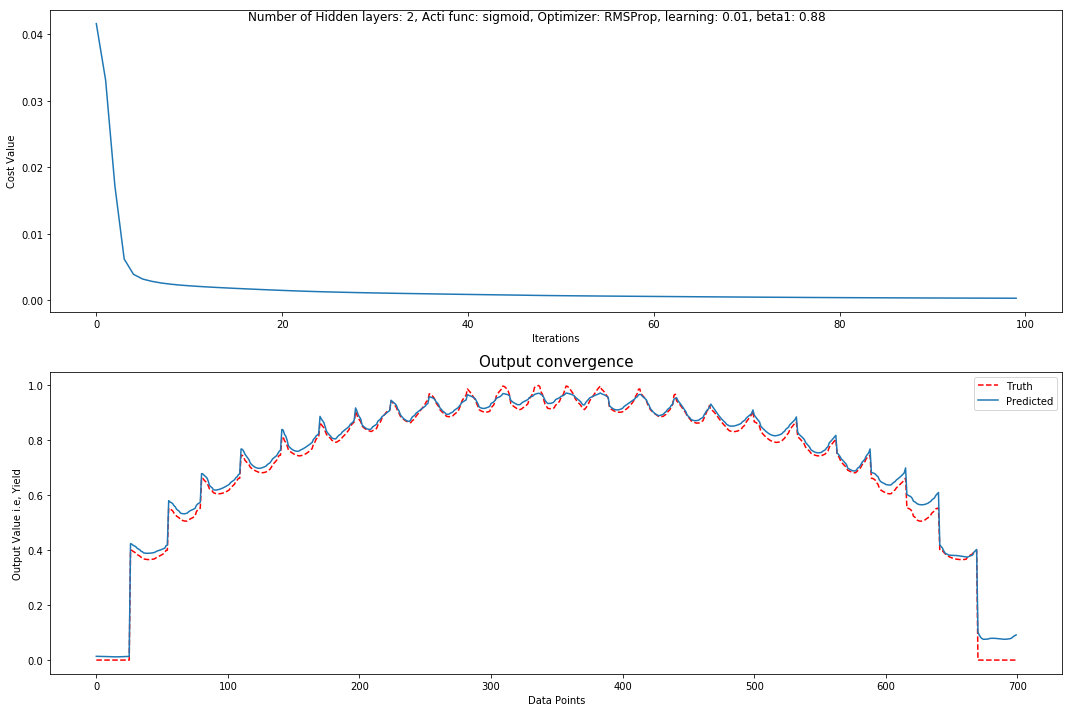

The cost in Testing is:  0.0003062140455759546
The Accuracy is : 97.84531432726908


In [3]:
hidden_layer_dims = [15,15]
model = my_neural_network(hidden_layer_dims)
file_name = 'Bigoni_resultant.txt'
model.load_dataset(file_name)
model.test_train_split()
model.NN_model(10000, 0.01,beta1=0.8,beta2=0.88,activation_function = "sigmoid", batching = False, batch_size= None,optimizer = 'RMSProp')